<h1 style='font-size:60px'>
    What is Dask?
<img src='logo.png' align='left' height='120' width='120' style='float: left; margin-right: 40px; margin-top: 1px;'/>
</h1>

<font size='4'> Henry Wilde | 
<i class='fa fa-github' aria-hidden='false'></i>
<i class='fa fa-twitter' aria-hidden='false'></i> @daffidwilde </font>
<hr>

### Dask is a parallel computing framework all about building graphs.

<br>
We can divide Dask into two main components:

* **High-level** data collections which mirror `np.array`, `list` and `pd.DataFrame`    


* **Low-level** task schedulers for executing task graphs

<br>

<img align='centre' src='collections-schedulers.png'>

# Parallelising code with `dask.delayed`
---

### Normal code

In [1]:
from time import sleep


def inc(x):
    sleep(0.5)
    return x + 1


def add(x, y):
    sleep(1)
    return x + y


def mul(x, y):
    sleep(0.5)
    return x * y


In [3]:
%%time

results = []
a = inc(1)
for i in range(3): 
    b = mul(i, a)
    c = add(a, b)
    results.append(c)

total = sum(results)
print(total)

12
CPU times: user 794 µs, sys: 1.36 ms, total: 2.16 ms
Wall time: 5.01 s


### Parallelised code


We can use `dask.delayed` either by wrapping it around a function or by using a decorator at the point of definition.

In either case, this indicates that the function should be executed lazily.

In [29]:
from dask import delayed


@delayed
def inc(x):
    sleep(0.5)
    return x + 1


@delayed
def add(x, y):
    sleep(1)
    return x + y


@delayed
def mul(x, y):
    sleep(0.5)
    return x * y


In [30]:
%%time

results = []
a = inc(1)
for i in range(3):
    b = mul(i, a)
    c = add(a, b)
    results.append(c)
    
total = delayed(sum)(results)

CPU times: user 352 µs, sys: 123 µs, total: 475 µs
Wall time: 419 µs


In [31]:
total


Delayed('sum-c9cb8381-6a33-4a2a-ae98-b8b6d596cd9e')

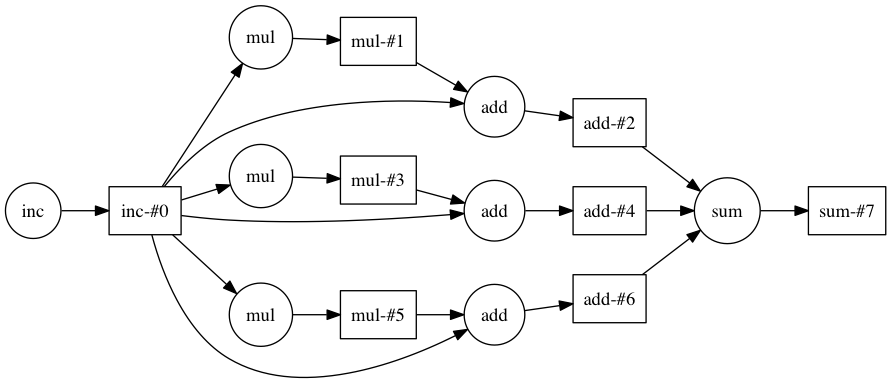

In [32]:
total.visualize(rankdir="LR")


In [8]:
%time total.compute()

CPU times: user 7.78 ms, sys: 4.01 ms, total: 11.8 ms
Wall time: 2.02 s


12

# Familiarity between `dask.dataframe` and `pandas.DataFrame`
---

### In Pandas, we might have something like this:

In [9]:
import pandas as pd
from glob import iglob

dt = {"CRSElapsedTime": "float64", "TailNum": "object"}


In [10]:
dfs = [pd.read_csv(csv, dtype=dt) for csv in iglob("nycflights/*.csv")]
df = pd.concat(dfs)


In [11]:
df.head()


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [12]:
df.groupby(df.Origin).DepDelay.mean()


Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

### The process is much the same in Dask:


In [13]:
import dask.dataframe as dd


In [14]:
%%time
ddf = dd.read_csv('nycflights/*.csv', dtype=dt)

CPU times: user 139 ms, sys: 55.2 ms, total: 194 ms
Wall time: 955 ms


In [15]:
ddf.head()


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [16]:
mean = ddf.groupby(ddf.Origin).DepDelay.mean()
mean


Dask Series Structure:
npartitions=1
    float64
        ...
Name: DepDelay, dtype: float64
Dask Name: truediv, 57 tasks

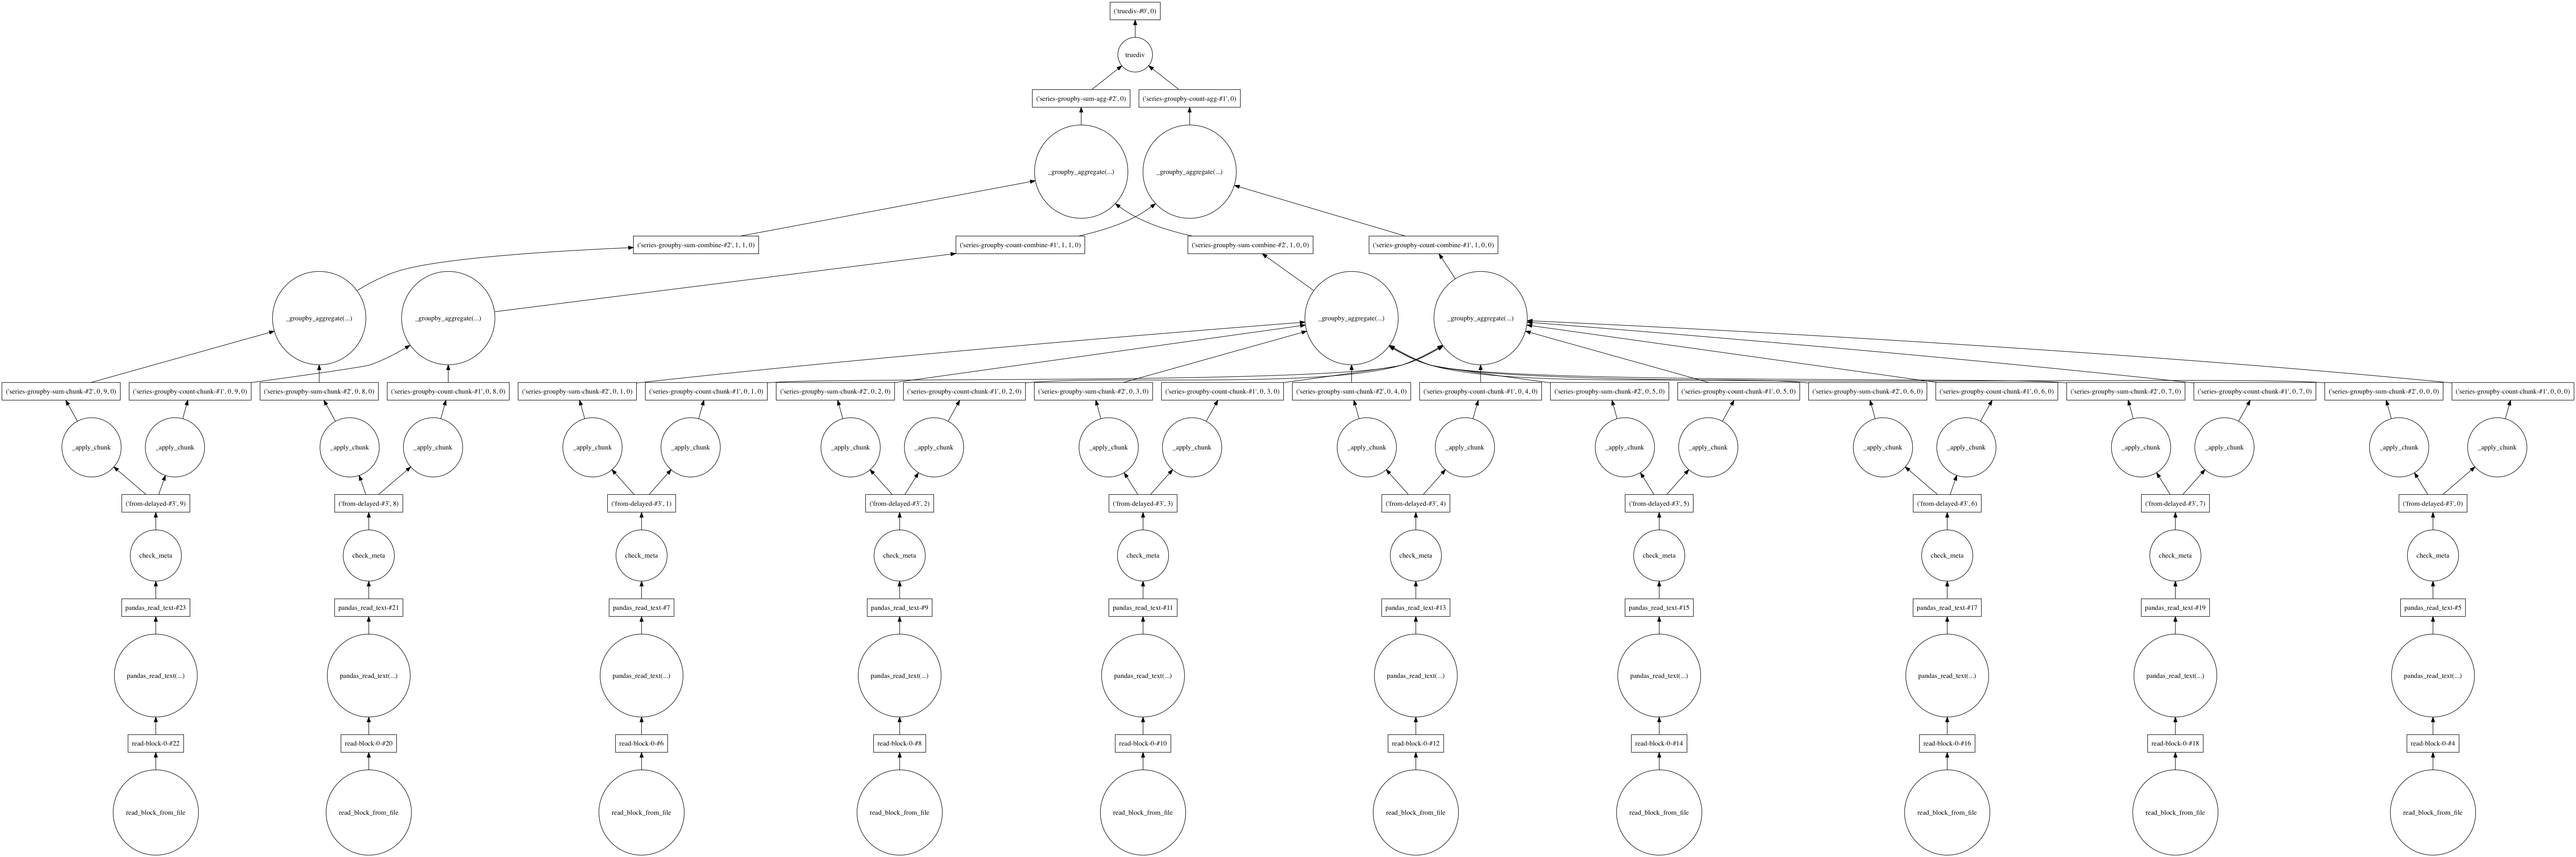

In [17]:
mean.visualize()


In [18]:
mean.compute()


Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

# Schedulers
---


There are four schedulers currently implemented in Dask:

-  **Threaded:**
 - Useful for numeric code such as `numpy` and `pandas` where the GIL is released 


- **Multiprocessing:**
 - Good for Python-bound code that requires multiple interpreters


- **Synchronous:**
 - Helps with debugging and profiling


- **Distributed:**
 - For working with a cluster of machines on larger tasks
 - Alternative to `multiprocessing` for better diagnostic tools